In [1]:
import som
import numpy as np
import math
import time
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local").appName("MapaAutoorganizado").getOrCreate()
sc = spark.sparkContext

In [2]:
import numba
from numba import cuda
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32
import numpy as np

@cuda.jit
def rand_weights(rng_states, d_weights):
    """
    Kernel para inicializar aleatoriamente la 'matriz' de pesos con valores 
    en el intervalo [0, 1) tomados de una distribución aleatoria
    :param rng_states Estados aleatorios
    :param d_weigths Vector de M * N * d valores que contendrá los pesos asociados a las neuronas
    """
    idx = cuda.grid(1)
    # Cogemos índices para pasar de array unidimensional a tridimensional
    n_rows, n_cols, d = d_weights.shape
    row = idx // (n_cols * d)
    col_d = idx % (n_cols * d)
    col = col_d // d
    i = col_d % d
    
    # Sacamos el aleatorio correspondiente
    if idx < d_weights.size:
        d_weights[row, col, i] = xoroshiro128p_uniform_float32(rng_states, idx)
    

In [3]:
"""
Implementación de un único kernel para ser ejecutado en cada partición del RDD.
"""
@cuda.jit
def som_iter(d_samples, d_weights, d_distances, d_nums, d_denums, sigma_squared):
    """
    Este kernel realiza el proceso de calcular las distancias euclídeas entre
    todas las muestras y los pesos de las neuronas. Encontrar la mejor BMU para
    una muestra y realizar el cálculo parcial de los pesos correspondientes.
    :param d_samples Conjunto de todas las muestras a evaluar.
    :param d_weights Array de filas * columnas * d valores con los pesos 
    asociados a cada una de las neuronas.
    :param d_distances Array de tamaño N * nneurons para almacenar
    las distancias
    :param d_nums Vector con los numeradores para el cálculo de la fórmula.
    :param d_denums Vector con los denominadores para el cálculo de la fórmula.
    :param sigma_squared Valor de sigma al cuadrado para el cáculo del vecindario.
    """
    # 0. Índices
    nrows, ncols, d = d_weights.shape
    nneurons = nrows * ncols
    
    
    sample_idx = cuda.blockIdx.x
    neuron_idx = cuda.threadIdx.x
    neuron_row = neuron_idx // ncols
    neuron_col = neuron_idx % ncols
    blockSize = cuda.blockDim.x
       
    # 1. Empezamos calculando la distancia euclídea de la muestra con las neuronas
    #    del bloque.
    shared_sample = cuda.shared.array(shape=0, dtype=numba.float32)
    
    # 1.a Cargamos la muestra del bloque en memoria compartida 
    for i in range(d // nneurons + 1):
        i_stride = i * nneurons
        my_pos = i_stride + cuda.threadIdx.x
        if my_pos < d:
            shared_sample[my_pos] = d_samples[sample_idx, my_pos]
            
    cuda.syncthreads()
    # 1.b Calculamos las distancias euclídeas que nos corresponden.
    if neuron_idx < nneurons:
        distance = 0.0
        for i in range(d):
            i_distance = shared_sample[i] - d_weights[neuron_row, neuron_col, i]
            distance += i_distance * i_distance
        d_distances[sample_idx, neuron_idx] = distance
    cuda.syncthreads()
    
    # 2. Realizamos la reducción
    # 2.a Declaramos la memoria compartida
    # (Pongo el tamaño máximo que puede usar, ya que sólo puedo indicar el
    # tamaño de uno de forma dinámica).
    shared_mem = cuda.shared.array(shape=1024, dtype=numba.float32)
    shared_idx = cuda.shared.array(shape=1024, dtype=numba.int32)
    
    # 2.b Inicializamos la memoria compartida
    #     rellanando con infinito a las posiciones que no utilizamos.
    if neuron_idx < nneurons:
        shared_mem[neuron_idx] = d_distances[sample_idx, neuron_idx]
    else:
        shared_mem[neuron_idx] = np.inf
        
    shared_idx[neuron_idx] = neuron_idx
    
    cuda.syncthreads()
    
    if blockSize >= 1024 and neuron_idx < 512:
        if shared_mem[neuron_idx + 512] < shared_mem[neuron_idx]:
            shared_mem[neuron_idx] = shared_mem[neuron_idx + 512]
            shared_idx[neuron_idx] = shared_idx[neuron_idx + 512]
    cuda.syncthreads()
    
    if blockSize >= 512 and neuron_idx < 256:
        if shared_mem[neuron_idx + 256] < shared_mem[neuron_idx]:
            shared_mem[neuron_idx] = shared_mem[neuron_idx + 256]
            shared_idx[neuron_idx] = shared_idx[neuron_idx + 256]
    cuda.syncthreads()
    
    if blockSize >= 256 and neuron_idx < 128:
        if shared_mem[neuron_idx + 128] < shared_mem[neuron_idx]:
            shared_mem[neuron_idx] = shared_mem[neuron_idx + 128]
            shared_idx[neuron_idx] = shared_idx[neuron_idx + 128]
    cuda.syncthreads()
    
    if blockSize >= 128 and neuron_idx < 64:
        if shared_mem[neuron_idx + 64] < shared_mem[neuron_idx]:
            shared_mem[neuron_idx] = shared_mem[neuron_idx + 64]
            shared_idx[neuron_idx] = shared_idx[neuron_idx + 64]
    cuda.syncthreads()
    
    if neuron_idx < 32:
        if shared_mem[neuron_idx + 32] < shared_mem[neuron_idx]:
            shared_mem[neuron_idx] = shared_mem[neuron_idx + 32]
            shared_idx[neuron_idx] = shared_idx[neuron_idx + 32]
        if shared_mem[neuron_idx + 16] < shared_mem[neuron_idx]:
            shared_mem[neuron_idx] = shared_mem[neuron_idx + 16]
            shared_idx[neuron_idx] = shared_idx[neuron_idx + 16]
        if shared_mem[neuron_idx + 8] < shared_mem[neuron_idx]:
            shared_mem[neuron_idx] = shared_mem[neuron_idx + 8]
            shared_idx[neuron_idx] = shared_idx[neuron_idx + 8]
        if shared_mem[neuron_idx + 4] < shared_mem[neuron_idx]:
            shared_mem[neuron_idx] = shared_mem[neuron_idx + 4]
            shared_idx[neuron_idx] = shared_idx[neuron_idx + 4]
        if shared_mem[neuron_idx + 2] < shared_mem[neuron_idx]:
            shared_mem[neuron_idx] = shared_mem[neuron_idx + 2]
            shared_idx[neuron_idx] = shared_idx[neuron_idx + 2]
        if shared_mem[neuron_idx + 1] < shared_mem[neuron_idx]:
            shared_mem[neuron_idx] = shared_mem[neuron_idx + 1]
            shared_idx[neuron_idx] = shared_idx[neuron_idx + 1]
    
    cuda.syncthreads()
    bmu = shared_idx[0]
    bmu_row = bmu // ncols
    bmu_col = bmu % ncols

    cuda.syncthreads()
    # 3. Realizamos la actualización de los pesos.
    if neuron_idx < nneurons:
        dist = (neuron_row - bmu_row) * (neuron_row - bmu_row) + \
               (neuron_col - bmu_col) * (neuron_col - bmu_col)
        # Si estamos dentro del rango de actualización.
        if dist <= sigma_squared:
            hck = math.exp(-dist/(2 * sigma_squared))
            # Guardamos sumatoria del denominador
            cuda.atomic.add(d_denums, neuron_row * ncols + neuron_col, hck)
            # Guardamos sumatoria del numerador
            for i in range(d):
                cuda.atomic.add(d_nums, neuron_row*ncols*d + neuron_col*d+i,
                                hck * shared_sample[i])


In [4]:
@cuda.jit
def finish_update(d_weights, partials, numParts):
    """
    Este kernel terminas las sumas parciales.
    Se ejecuta en un único nodo de Spark.
    
    :param weights Array de pesos de neuronas
    :param partials Array con sumas parciales
    :param numParts Número de resultados parciales a procesar.
    :param nrows Número de filas en la capa de salida.
    :param ncols Número de columnas en la capa de salida.
    :param d Dimensión de cada muestra.
    
    Estrucutra de bloques
    ---------------------
    Lanzamos nrows * ncols // tpb + 1 bloques.
    """
    idx = cuda.grid(1)
    nrows, ncols, d = d_weights.shape
    if idx < nrows * ncols:
        row = idx // ncols
        col = idx % ncols
        
        # a) Sumamos todos los parciales en el primer array
        numsize = nrows * ncols * d
        densize = nrows * ncols
        fullsize = numsize + densize
        for i in range(numParts - 1):
            # Suma de numeradores
            for k in range(d):
                partials[row * ncols * d + col * d + k] += partials[fullsize * i + row * ncols * d + col * d + k]
            # Suma de denominadores
            partials[numsize + row * ncols + col] += partials[fullsize * i + numsize + row * ncols + col]
            
    cuda.syncthreads()
    
    if idx < nrows * ncols:
        # b) Si no es 0 el denominador realizamos la división y cambiamos pesos actuales
        if partials[numsize + row * ncols + col] != 0:
            for k in range(d):
                d_weights[row, col, k] = partials[row*ncols*d + col*d +k] / \
                                         partials[numsize + row * ncols + col]

In [5]:
"""
Spark con GPU
"""
def gpu_work_iter(weights, sigma_squared):
    # Declarada función interna para devolverla y poder utilizar
    # múltiples parámetros al llamar a mapPartitions
    def _gpu_work(data):
        # 1. Procesamos el dataset
        inp = np.asarray(list(data), dtype=np.float32)
        rows, cols, d = weights.shape
        nneurons = rows * cols
        N = inp.shape[0]
    
        # 2. Pasamos los datos a las memorias del dispositivo
        d_samples = cuda.to_device(inp)
        d_weights = cuda.to_device(weights)
        d_distances = cuda.device_array((N, nneurons), dtype=np.float32)
        nums = np.zeros(rows * cols * d, np.float32)
        denums = np.zeros(rows * cols, np.float32)
        d_nums = cuda.to_device(nums)
        d_denums = cuda.to_device(denums)
        
        # 3. Tomamos el número de hebras por bloque
        if nneurons > 1024:
            raise Exception('Número de neuronas superior al límite')
        elif 512 < nneurons <= 1024:
            tpb = 1024
        elif 256 < nneurons <= 512:
            tpb = 512
        elif 128 < nneurons <= 256:
            tpb = 256
        elif 64 < nneurons <= 128:
            tpb = 128
        else:
            tpb = 64
            
        # 3. Lanzamos el kernel.
        sm_size = 4 * d # Memoria compartida para almacenar una muestra por bloque
        som_iter[N, tpb, 0, sm_size](d_samples, d_weights, d_distances, d_nums,
                                     d_denums, sigma_squared)
        
        return d_nums.copy_to_host(), d_denums.copy_to_host()
    return _gpu_work

In [6]:
def spark_gpu_batch_som(rdd_data, d, max_iters, rows, cols, smooth_iters=None, sigma_0=10, 
                          sigma_f=0.1, tau=400, seed=None, tpb=1024):
    
    # 1. Inicializamos pesos aleatorios
    d_weights = cuda.device_array((rows, cols ,d), np.float32)
    rng_states = create_xoroshiro128p_states(rows * cols * d, seed=seed)
    rand_weights[(d_weights.size) // tpb + 1, tpb](rng_states, d_weights)
     
    weights = d_weights.copy_to_host()
    # 2. Bucle del algoritmo
    for t in range(max_iters):
        # 2.a Actualizamos los parámetros de control si procede
        if smooth_iters is None or t < max_iters:
            sigma = sigma_0 * math.exp((-t/tau))
        else:
            sigma = sigma_f
            
        sigma_squared = sigma * sigma
        
        # 2.b Cada nodo del clúster de spark trabajará con un subconjunto
        # de las muestras del RDD para encontrar la BMU y realizar la suma
        # parcial de su ecucación de actualización de pesos
        out = rdd_data.mapPartitions(gpu_work_iter(weights, sigma_squared))
        
        # 2.c En un único nodo usamos la GPU para juntar todas las sumas parciales obtenidas
        #   y realizar la división
        out = out.collect()
        numParts = len(out) // 2

        partials = np.concatenate(out)
        finish_update[rows * cols // tpb + 1, tpb](weights, partials, numParts)
       
    return weights



In [7]:
"""
Ejemplo de las caras
"""
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
    
faces = fetch_olivetti_faces()['data']
rows = 5
cols = 6
d=faces.shape[1]
iters = 50
smooth_iters = 25
sigma_0 = 3
tau = 50
rdd = sc.parallelize(faces)

In [8]:
"""
GPU con tantas particiones del RDD como core de CPU
"""
inicio = time.time()
weights=spark_gpu_batch_som(rdd, d, iters, rows, cols, smooth_iters, sigma_0, 0.1, tau, seed=2)
fin = time.time()

GPU tantas particiones del RDD como cores de CPU
Tiempo ejecución (s) 322.0829794406891
Error de cuantificación: 6.5665120542
Error topográfico: 0.015


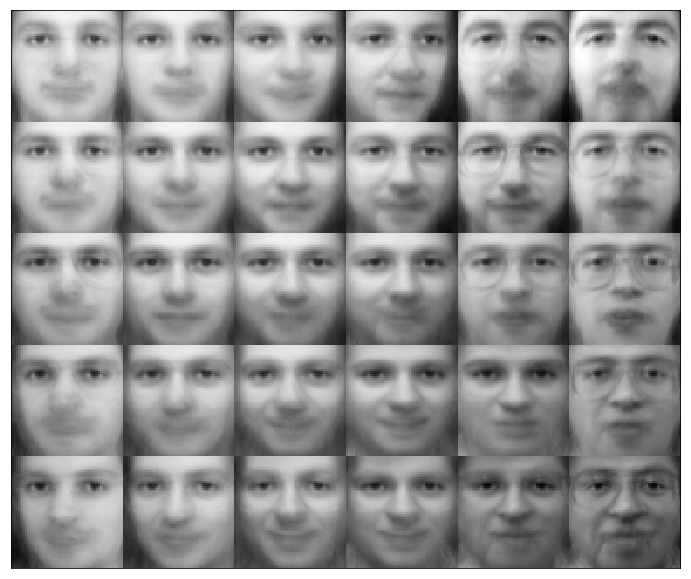

In [9]:
def pintar(texto, pesos):
    W = pesos
    pattern_length = faces.shape[1]
    pattern_width = pattern_height = int(np.sqrt(pattern_length))
    matrix_w = np.empty((rows * pattern_height, cols * pattern_width))


    for i in range(rows):
        for j in range(cols):
            matrix_w[i * pattern_height:i * pattern_height + pattern_height, 
    j * pattern_height:j * pattern_height + pattern_width] = W[i, j].reshape((pattern_height, pattern_width)) * 255.0
    fig, ax = plt.subplots(figsize=(12,12))

    ax.matshow(matrix_w.tolist(), cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    print(texto)
    print('Tiempo ejecución (s)', fin - inicio)
    print('Error de cuantificación:', som.quantification_error(faces, weights) )
    print('Error topográfico:', som.topography_error(faces, weights))
    plt.show()
pintar('GPU tantas particiones del RDD como cores de CPU', weights)

In [10]:
"""
CPU con tantas particiones del RDD como core de CPU
"""
inicio = time.time()
weights = som.spark_cpu_batch_som(rdd, d, iters, rows, cols, smooth_iters, sigma_0, 0.1, tau, seed=2)
fin = time.time()

CPU tantas particiones del RDD como cores de CPU
Tiempo ejecución (s) 224.94688868522644
Error de cuantificación: 6.5898699431
Error topográfico: 0.0275


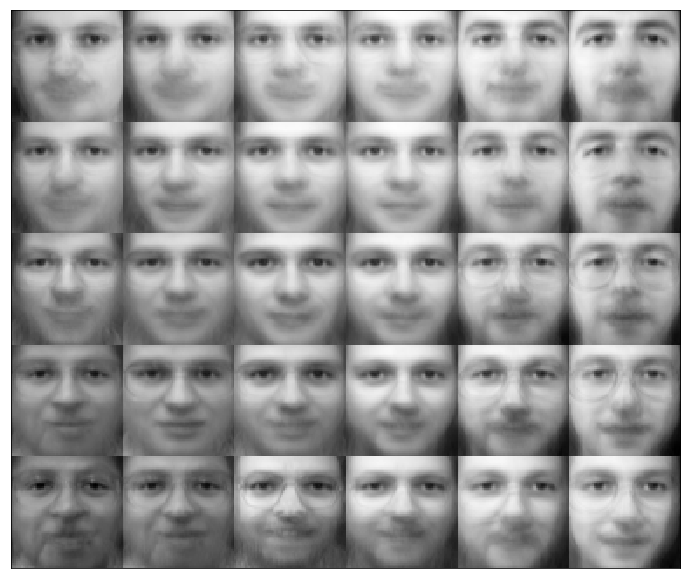

In [11]:
pintar('CPU tantas particiones del RDD como cores de CPU', weights)

In [12]:
# Extra: probamos con lanzar un RDD con 1 partición para que todo se ejecute a la vez,
rdd_2 = rdd.repartition(1)
aux = rdd_2.take(1)

In [13]:
rdd_2.getNumPartitions()

1

In [14]:
"""
GPU con 1 particion del RDD
"""
inicio = time.time()
weights=spark_gpu_batch_som(rdd_2, d, iters, rows, cols, smooth_iters, sigma_0, 0.1, tau, seed=2)
fin = time.time()

GPU 1 partición del RDD
Tiempo ejecución (s) 78.34819197654724
Error de cuantificación: 6.59241902351
Error topográfico: 0.035


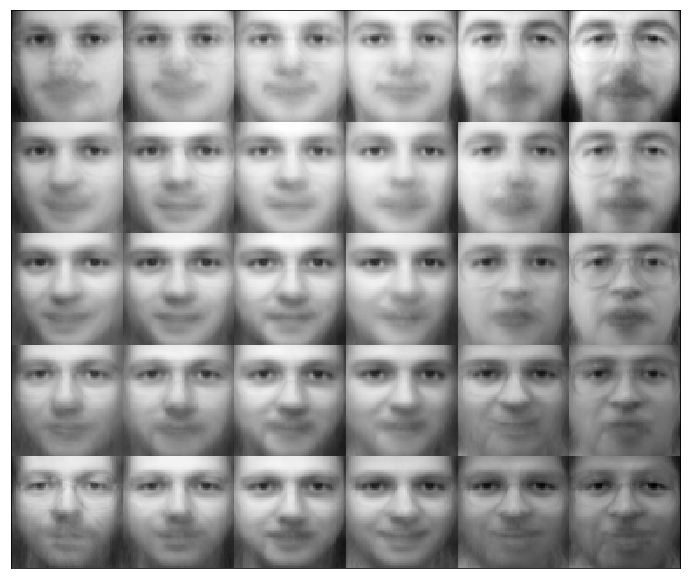

In [15]:
pintar('GPU 1 partición del RDD', weights)

In [16]:
"""
CPU con 1 particion del RDD
"""
inicio = time.time()
weights=som.spark_cpu_batch_som(rdd_2, d, iters, rows, cols, smooth_iters, sigma_0, 0.1, tau, seed=2)
fin = time.time()

CPU 1 partición del RDD
Tiempo ejecución (s) 43.77848982810974
Error de cuantificación: 6.58433738167
Error topográfico: 0.03


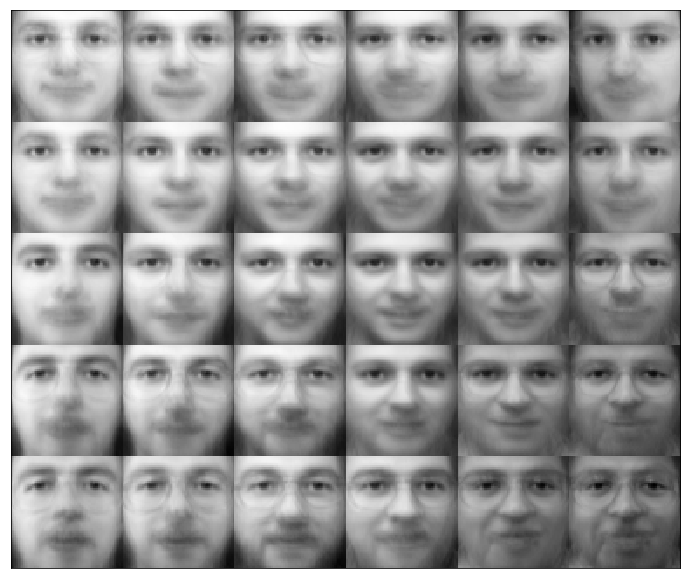

In [17]:
pintar('CPU 1 partición del RDD', weights)

In [18]:
"""
Cosas curiosas
Esta vez la versión de GPU para 50 iteraciones me funciona 20 segundos más rápido que la versión anterior
con los 3 kernels (me parece demasiada diferencia).

Tanto la CPU como la GPU tardan menos con menos particiones del RDD que procesar. 

La CPU tarda menos que la GPU. Eso creo que es normal porque hay un número de muestras bajo que evaluar (400)
y en cada una de las 50 iteraciones hay que hacer transferencias de datos host->dispositivo dispositivo->host.
Cuando el número de muestras era más alto se conseguía ganancia sin problemas.
"""

'\nCosas curiosas\nEsta vez la versión de GPU para 50 iteraciones me funciona 20 segundos más rápido que la versión anterior\ncon los 3 kernels (me parece demasiada diferencia).\n\nTanto la CPU como la GPU tardan menos con menos particiones del RDD que procesar. \n\nLa CPU tarda menos que la GPU. Eso creo que es normal porque hay un número de muestras bajo que evaluar (400)\ny en cada una de las 50 iteraciones hay que hacer transferencias de datos host->dispositivo dispositivo->host.\nCuando el número de muestras era más alto se conseguía ganancia sin problemas.\n\n'